_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote, Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

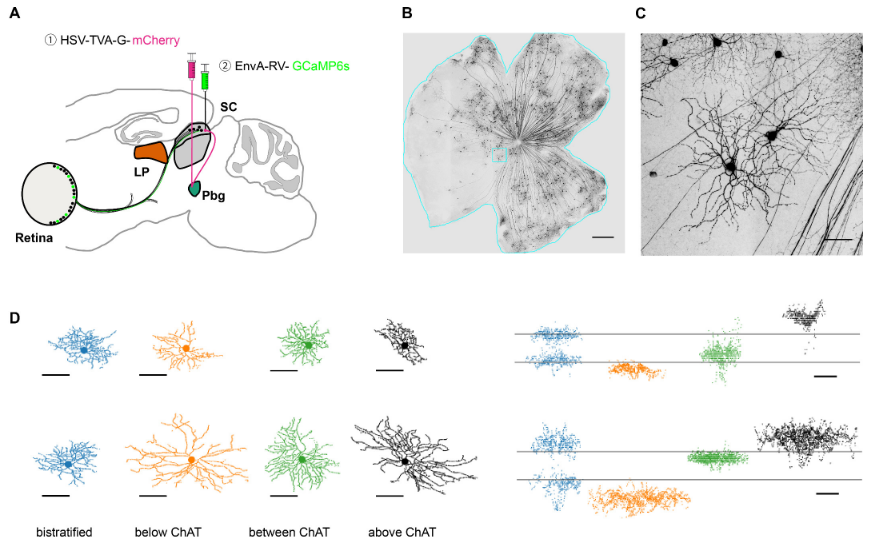

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [1]:
import pandas as pd
import numpy as np
import os


current_dir = os.getcwd()
if not current_dir.endswith("notebooks"):
    os.chdir(os.path.join(current_dir, "notebooks"))
os.chdir("..")
from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

Last updated: 2025-06-22 23:16:41Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.36.0

sklearnv: not installed

seaborn   : 0.13.2
morphopy  : 0.7.2
pandas    : 2.2.3
numpy     : 2.2.5
matplotlib: 3.10.3

Watermark: 2.5.0



In [2]:
plt.style.use("matplotlib_style.txt")

# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [3]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [4]:
# import swc file
current_dir = os.getcwd()

if not current_dir.endswith("notebooks"):
    os.chdir(os.path.join(current_dir, "notebooks"))

PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [5]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

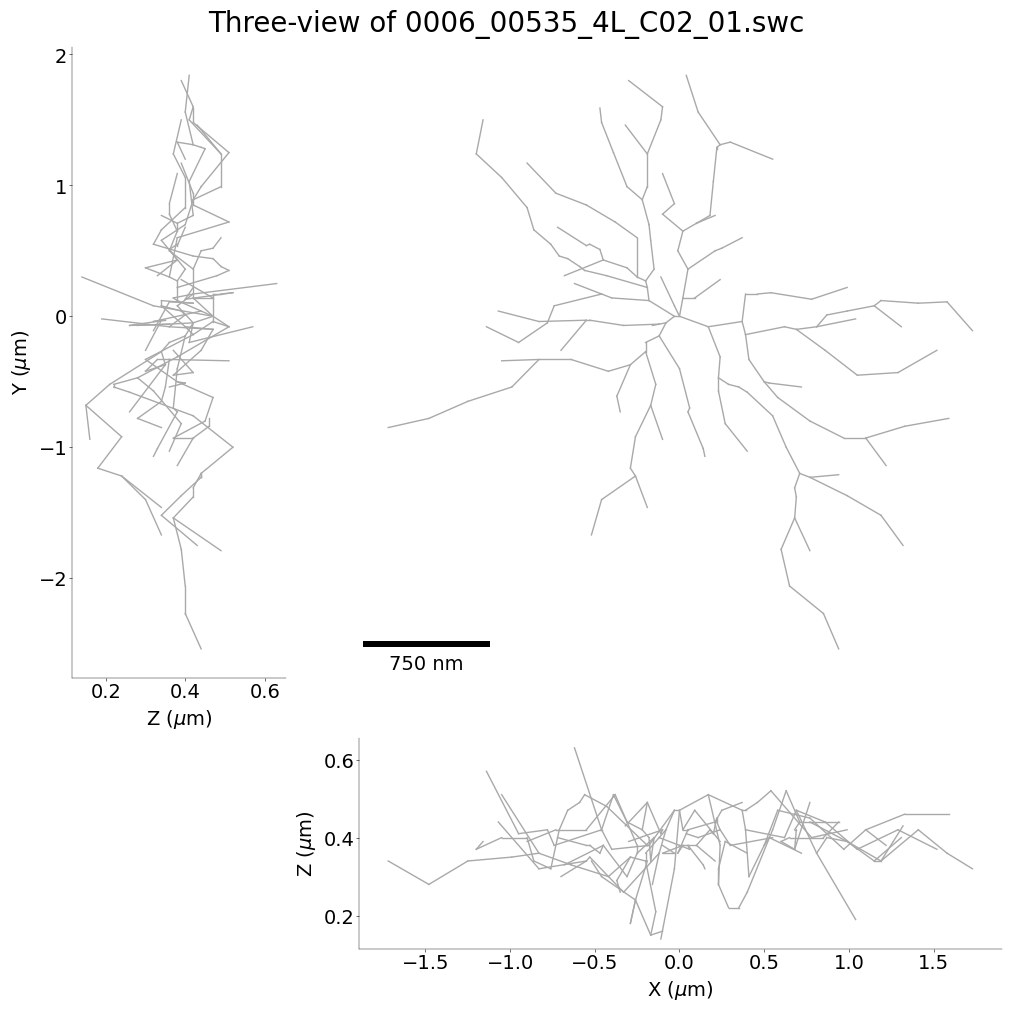

In [6]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------
# load the example cell
example_cell = file_manager.load_swc_file(
    filename=filepath, pca_rot=False, soma_center=False
)
# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------
fig = plt.figure(figsize=(10, 10))


show_threeview(example_cell, fig=fig)


fig.suptitle(f"Three-view of {filename}", fontsize=20)

plt.show()

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:**
Overall the neuron has a very planar/flat dendritic with only a small spread along the z-axis. Additionally, it appears to be rather apolar meaning that it is difficult to distinguish a clear apical dendrite from a basal axon. The dendritic structure is very similar to a star, which is why it is often referred to as a "starburst" morphology. 

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [ ]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    neurons = []

    # ----------------------------------------------------------
    # use `file_manager` to import all reconstructions (0.5 pts)
    # Note the list should be sorted by filename.
    # ----------------------------------------------------------

    # get all files in PATH in ascending order
    if not os.path.exists(path):
        raise FileNotFoundError(f"The path {path} does not exist.")
    files = sorted(os.listdir(path))

    # loop through all files
    for file in files:
        if file.endswith(".swc"):
            # load the swc file
            neuron = file_manager.load_swc_file(
                filename=os.path.join(path, file), pca_rot=False, soma_center=False
            )

            # append to list
            neurons.append(neuron)

    return neurons


neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [8]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics


# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------

ms_list = []
for neuron in neurons:
    ms = compute_morphometric_statistics(neuron)
    ms_list.append(ms)
# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr` as index (0.5 pts)
# -----------------------------------------------------------------------------------

morphometric_statistics = pd.concat(ms_list, axis=0, ignore_index=True)
morphometric_statistics.index = labels["Cell_nr"]
morphometric_statistics.index.name = "Cell_nr"
morphometric_statistics.head()

,branch_points,width,depth,height,tips,stems,total_length,avg_thickness,max_thickness,total_surface,...,median_intermediate_segment_pl,median_terminal_segment_pl,log_max_tortuosity,log_min_tortuosity,log_median_tortuosity,max_branch_angle,min_branch_angle,mean_branch_angle,max_degree,tree_asymmetry
Cell_nr,,,,,,,,,,,,,,,,,,,,,
2,66.0,4.12,5.96,0.54,69.0,3.0,65.793587,1.0,1.0,413.393297,...,0.334798,0.456196,0.253612,0.0,0.005766,124.974479,7.286952,50.402105,3.0,0.726199
3,18.0,3.07,2.66,0.68,23.0,1.0,18.657365,1.0,1.0,117.227681,...,0.345014,0.349991,0.285133,0.0,0.000564,110.367090,18.036960,57.088068,3.0,0.738502
4,54.0,5.05,3.53,0.72,61.0,6.0,41.349847,1.0,1.0,259.808753,...,0.202111,0.281069,0.312270,0.0,0.000000,131.508679,25.596621,59.646776,3.0,0.706943
6,36.0,3.45,4.38,0.49,39.0,4.0,32.249580,1.0,1.0,202.630089,...,0.217084,0.412995,0.251400,0.0,0.017747,130.034126,16.436535,54.683803,2.0,0.601296
7,31.0,4.13,3.86,0.58,40.0,7.0,34.647295,1.0,1.0,217.695372,...,0.248395,0.530086,0.217363,0.0,0.024678,104.036243,2.970445,55.498150,3.0,0.579942


Now let's visualize the data.

Number of morphometric features:  28


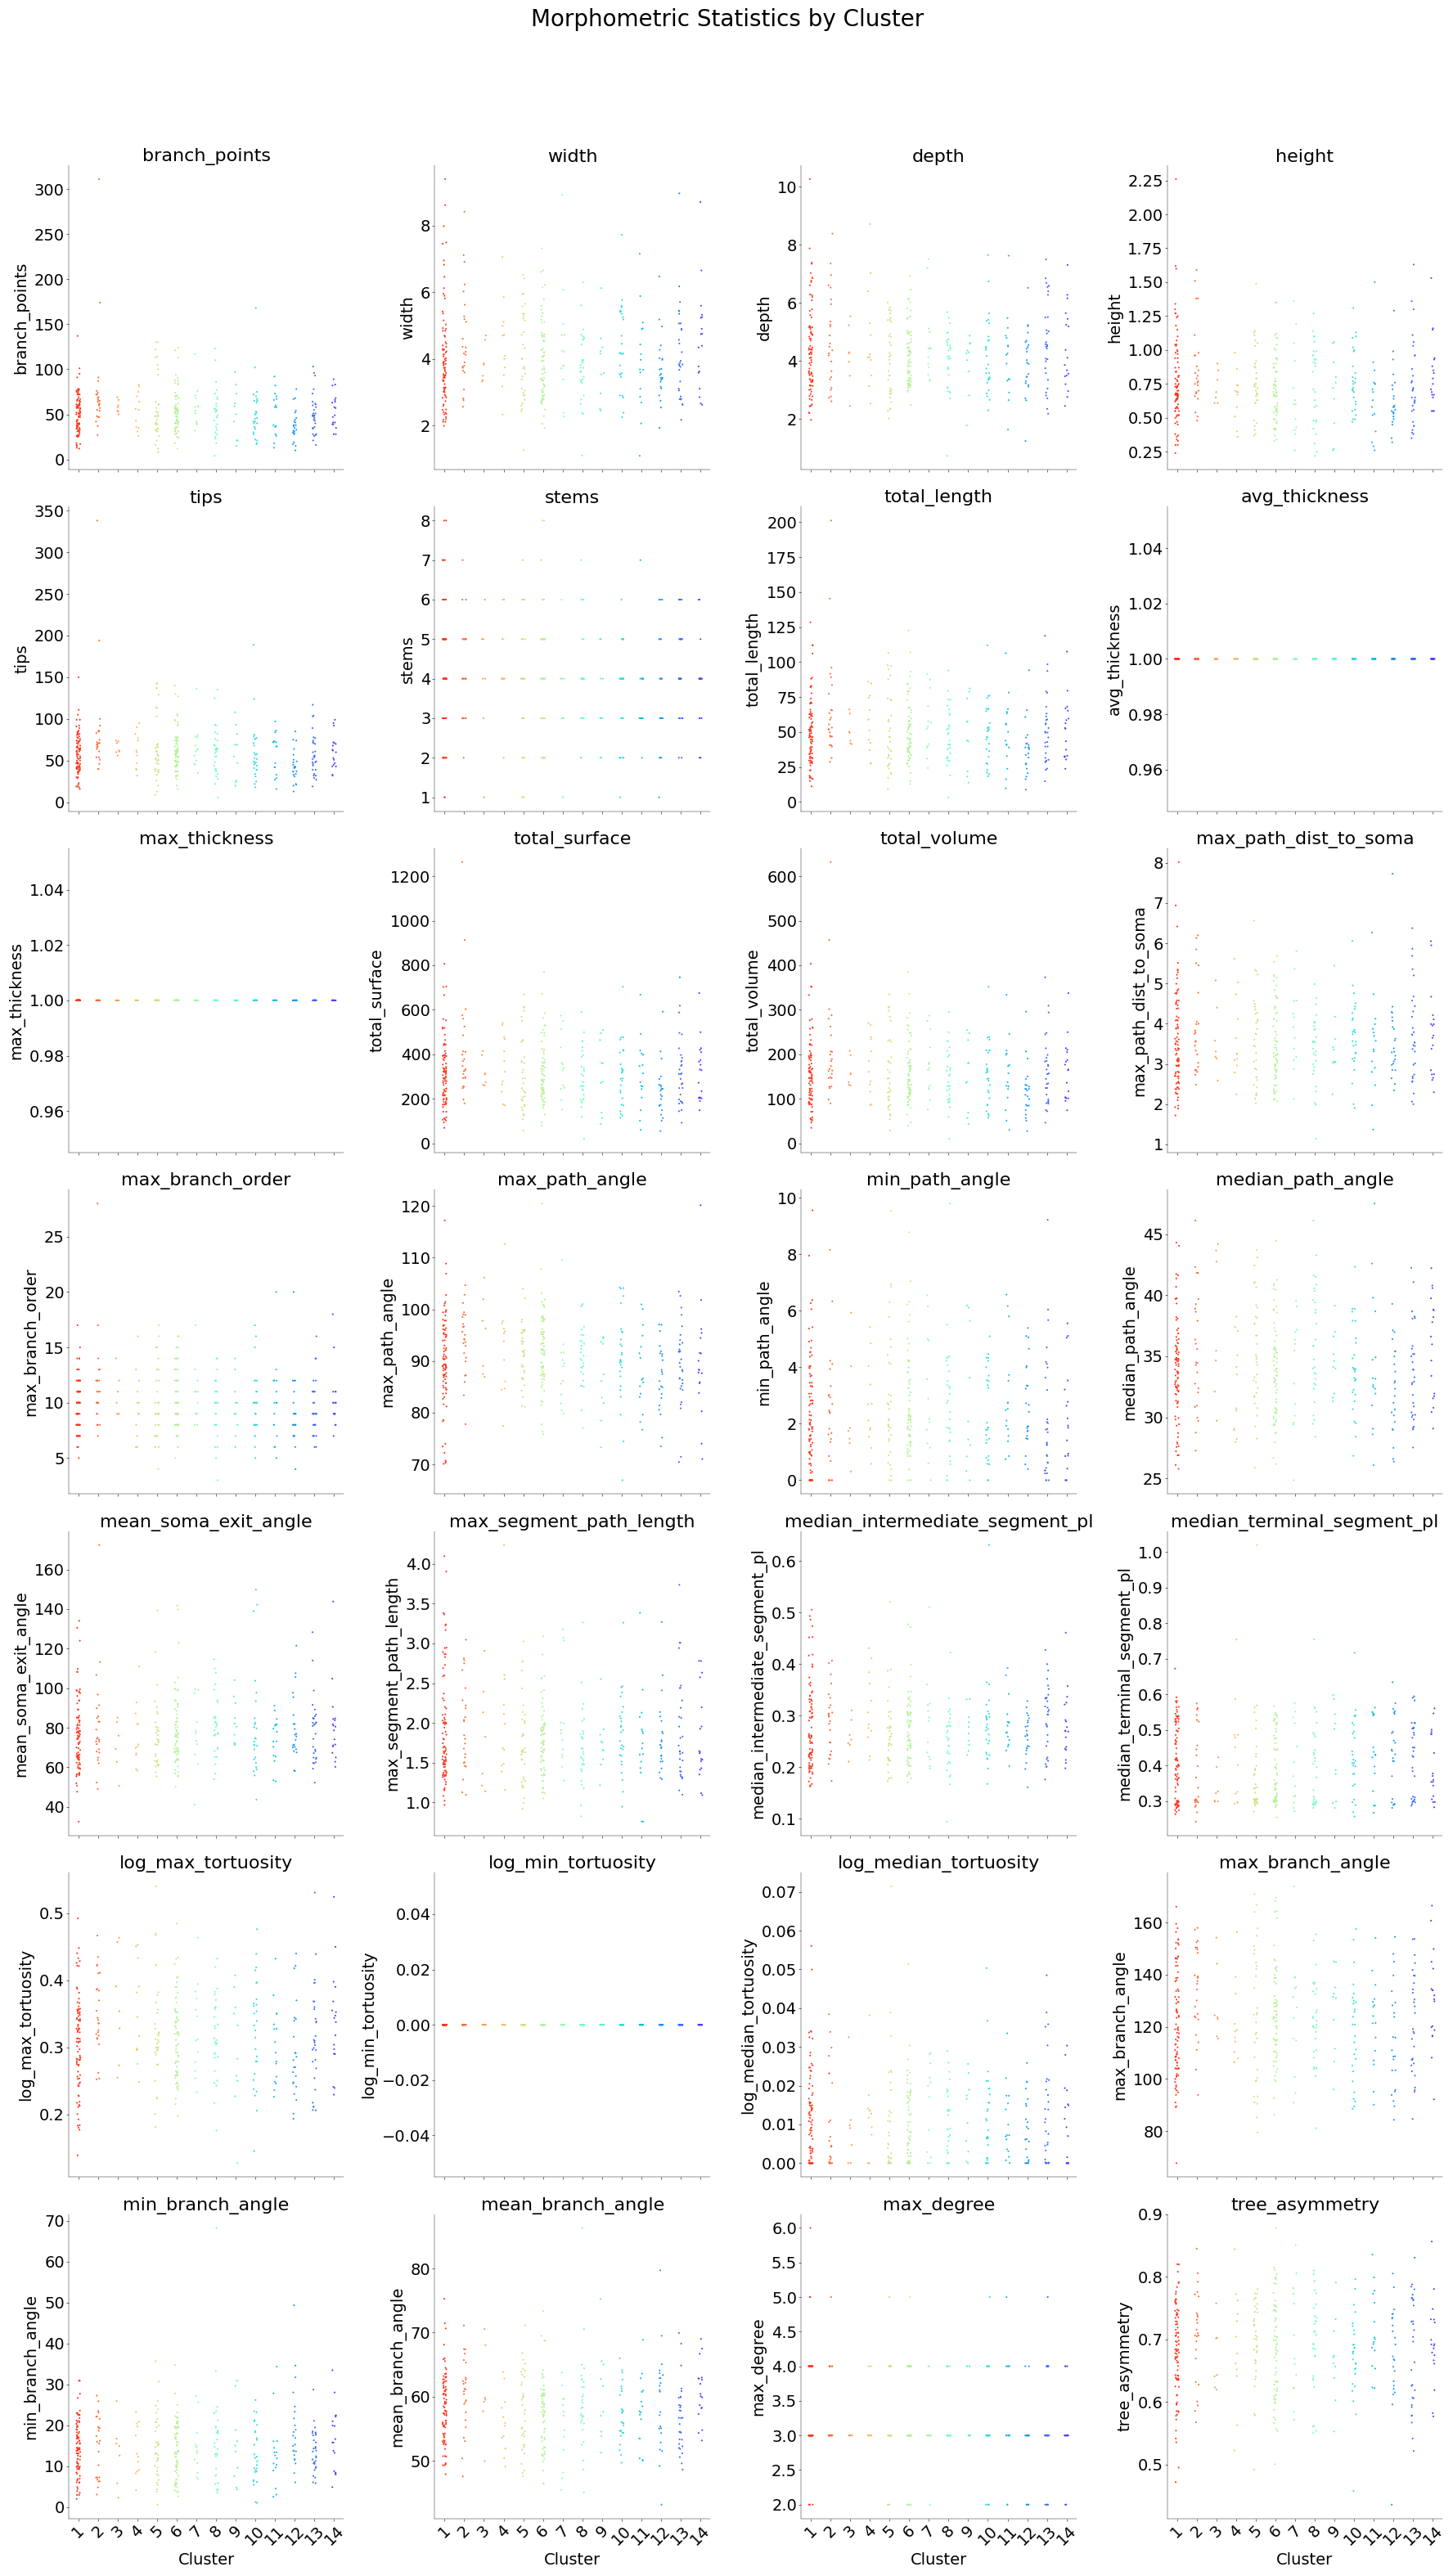

In [9]:
features = morphometric_statistics.columns.values
print("Number of morphometric features: ", len(features))


fig, axes = plt.subplots(7, 4, figsize=(18, 30), sharex=True)
axes = axes.flatten()

# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------
for i, feature in enumerate(features):
    ax = axes[i]
    sns.stripplot(
        x=labels["cluster"],
        y=morphometric_statistics[feature],
        ax=ax,
        palette=colors,
        jitter=True,
        alpha=1,
        size=3,
    )
    ax.set_title(feature, fontsize=16)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feature)
    ax.set_xticklabels(cluster_label, rotation=45)
plt.tight_layout()
plt.suptitle("Morphometric Statistics by Cluster", fontsize=20, y=1.05)
plt.show()

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

For many statistics it is visible that the different clusters follow different distributions. It can be noted though, that the variance for most statistics is quite high compared to the differences in means between clusters. However, avg_thickness (constant value)
max_thickness (constant values), log_min_tortuosity (constant values), stems (cells cluster around a small number of different values) max_degree (cells cluster arounda small set of values) are genuinly non-informative.

2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

Advantages:
-  Each feature has a clear biological or geometric meaning, making it easy to understand the results.
-  Compact, low-dimensional representation of a complex object (i.e., suitable for standard machine learning algorithms)

Disadvantages:
- Infomation loss <-> dimensionality reduction: By summarizing the morphology into a set of single numbers, they lose a significant amount of spatial information about the detailed arrangement and shape of the dendritic tree.

- Selection-Bias: Measurs are pre-defined and might miss subtle or complex shape features that are important for distinguishing cell types not captured by the chosen statistics.

## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [10]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_data - morphometric_data.mean()
) / morphometric_data.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

In [11]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them  for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------
all_coords = np.array(
    [
        attr["pos"]  # 'pos' is [x, y, z]
        for neuron in neurons
        for _, attr in neuron.get_graph().nodes(data=True)
    ]
)
r_min_x, r_min_y, r_min_z = all_coords.min(axis=0)
r_max_x, r_max_y, r_max_z = all_coords.max(axis=0)
print(f"r_min_x: {r_min_x:.2f}, r_max_x: {r_max_x:.2f}")
print(f"r_min_y: {r_min_y:.2f}, r_max_y: {r_max_y:.2f}")
print(f"r_min_z: {r_min_z:.2f}, r_max_z: {r_max_z:.2f}")

r_min_x: -6.34, r_max_x: 5.14
r_min_y: -5.49, r_max_y: 5.36
r_min_z: -1.50, r_max_z: 1.86


In [12]:
from morphopy.computation.feature_presentation import compute_density_maps

# ---------------------------------------------------------------------------------
# complete the config dict and compute the z-density maps for each neuron (1 pts)
# ---------------------------------------------------------------------------------
config_global = dict(
    distance=1,  # resampling distance in microns
    n_bins_x=20,  # number of bins along x-axis
    n_bins_y=20,  # number of bins along y-axis
    n_bins_z=20,  # number of bins along z-axis
    density=True,  # return density maps (normalized counts)
    smooth=True,  # apply Gaussian smoothing
    sigma=1,  # standard deviation for Gaussian kernel
    r_min_x=r_min_x,  # global minimum x-coordinate for bin edges
    r_min_y=r_min_y,  # global minimum y-coordinate for bin edges
    r_min_z=r_min_z,  # global minimum z-coordinate for bin edges
    r_max_x=r_max_x,  # global maximum x-coordinate for bin edges
    r_max_y=r_max_y,  # global maximum y-coordinate for bin edges
    r_max_z=r_max_z,  # global maximum z-coordinate for bin edges
)

density_maps = [compute_density_maps(neuron, config_global) for neuron in neurons]

# extract the z density map
dm_z = np.array([res["z_proj"]["data"] for res in density_maps])

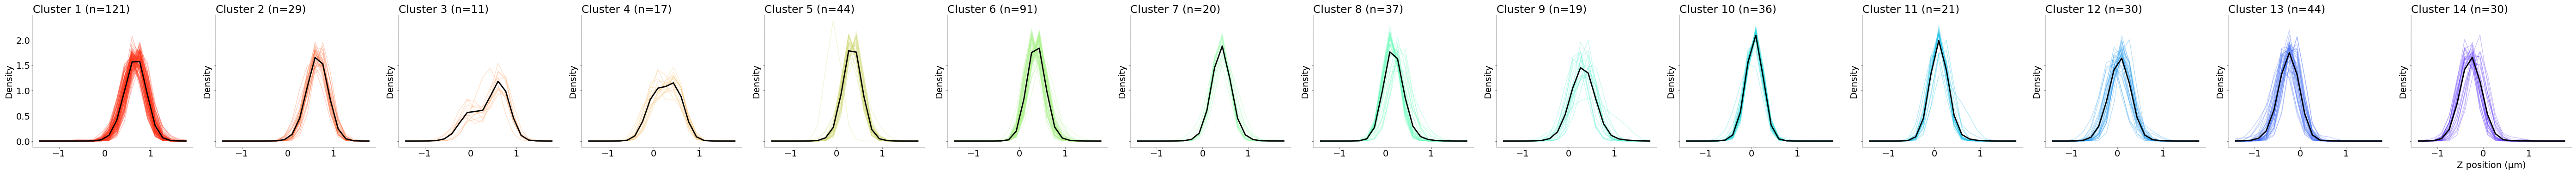

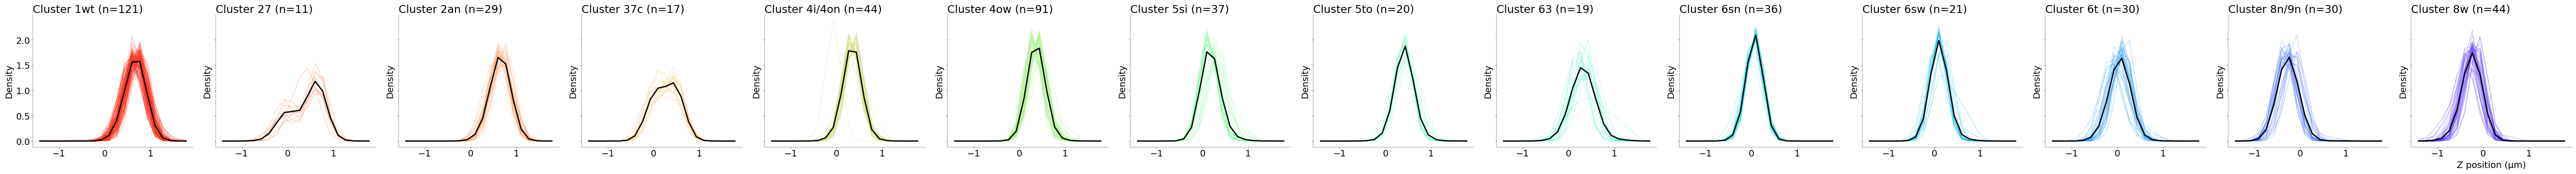

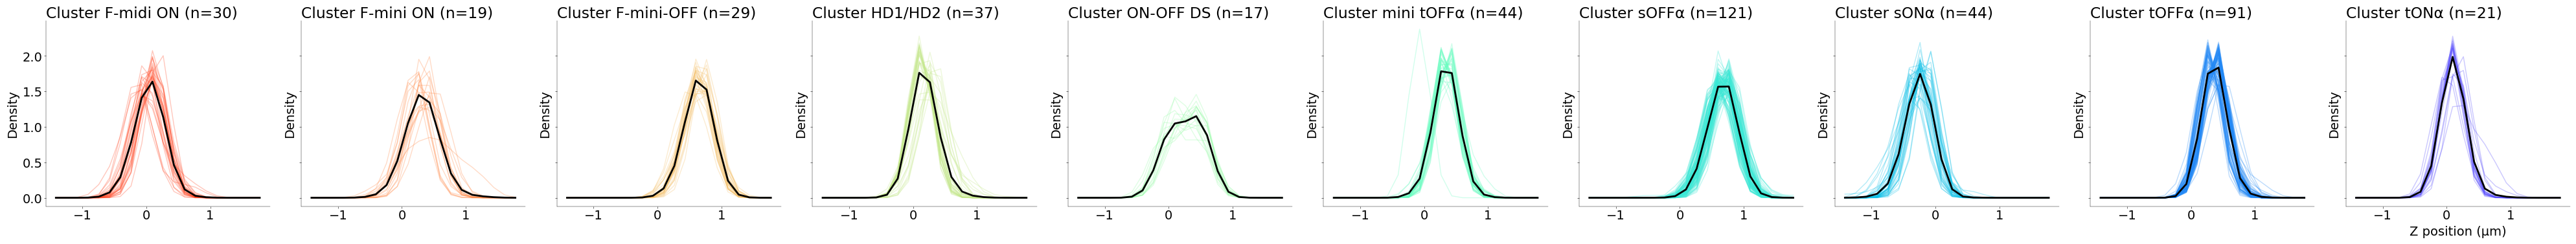

In [13]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# --------------------------------------------------------------------
ez_edges = density_maps[0]["z_proj"]["edges"][0]  # bin edges for z
z_centers = (ez_edges[:-1] + ez_edges[1:]) / 2
import seaborn as sns


def cluster_info(labels, cluster_type):
    lab = labels[cluster_type].reset_index(drop=True)
    cat = pd.Categorical(lab)
    categories = cat.categories
    n_cls = len(categories)
    colors = sns.color_palette("rainbow_r", n_cls)

    return cat, categories, n_cls, colors


def plot_z_by_cluster(dm_z, labels_df, cluster_type):
    """
    dm_z: array (n_neurons, n_bins_z)
    labels_df: DataFrame with cluster assignments
    cluster_type: str, one of ['clusterA','clusterB','clusterC','cluster']
    """

    cat, categories, n_cls, colors = cluster_info(labels_df, cluster_type)

    fig, axes = plt.subplots(1, n_cls, figsize=(4 * n_cls, 4), sharex=True, sharey=True)

    for i, cl in enumerate(categories):
        ax = axes[i] if n_cls > 1 else axes
        idx = np.where(cat == cl)[0]

        for j in idx:
            ax.plot(z_centers, dm_z[j], color=colors[i], alpha=0.3)

        mean_curve = dm_z[idx].mean(axis=0)
        ax.plot(z_centers, mean_curve, linewidth=2, color="black", label=f"Class {cl}")

        ax.set_ylabel("Density")
        ax.set_title(f"Cluster {cl} (n={len(idx)})", loc="left")

    axes[-1].set_xlabel("Z position (µm)")
    plt.tight_layout()
    plt.show()


# repeat for all cluster types
cluster_types = ["cluster", "clusterB", "clusterC"]
for ctype in cluster_types:
    plot_z_by_cluster(dm_z, labels, ctype)

### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:** the z-directions corresponds to the depth in the inner plexiform layer (IPL) of the retina. The plot highlights how deep neurons of specific clusters tend to be have their branches in the IPL. The clustering indices of the ClusterA clustering seem to be sorted going from the must upward to the most downward located cell cluster. 

2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:** The soma of the cell in task 1 is located at (0.  , 0.  , 0.47) and most of its nodes are at z-positions between 0.2 and 0.6. Visual inspection suggests that slightly more nodes are in the upper half of the z-range. This suggests that the cell is most likely from one of the clusters like clusters 5 to 8 which are slightly but not too pronounced above the 0 point and are not spread as wide.


## Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [14]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------
X_stats = morphometric_statistics.fillna(morphometric_statistics.mean())
X_density = dm_z

# Initialize t-SNE model
tsne = TSNE(n_components=2, perplexity=100, random_state=17)
tsne = TSNE(n_components=2, perplexity=100, random_state=17)
# Compute embeddings
emb_stats = tsne.fit(X_stats)
emb_density = tsne.fit(X_density)

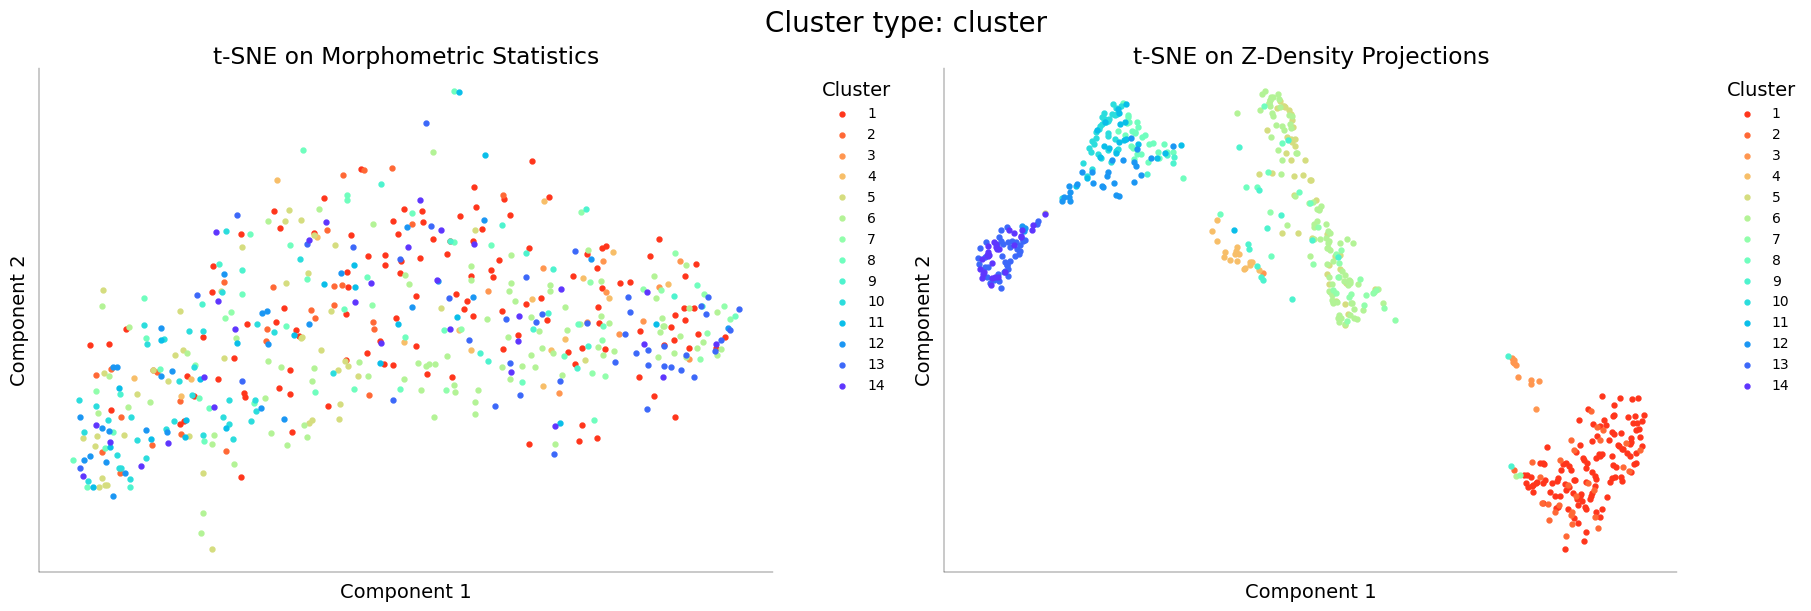

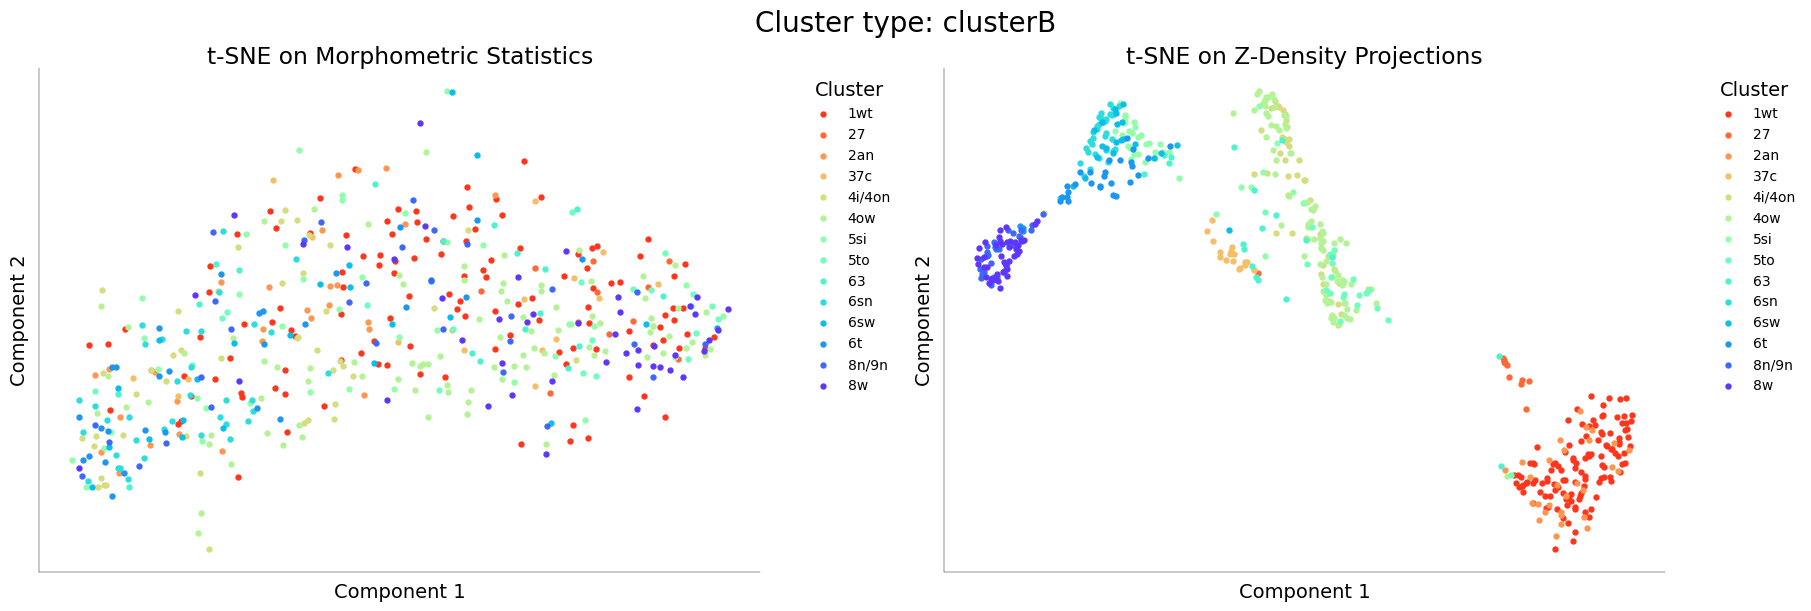

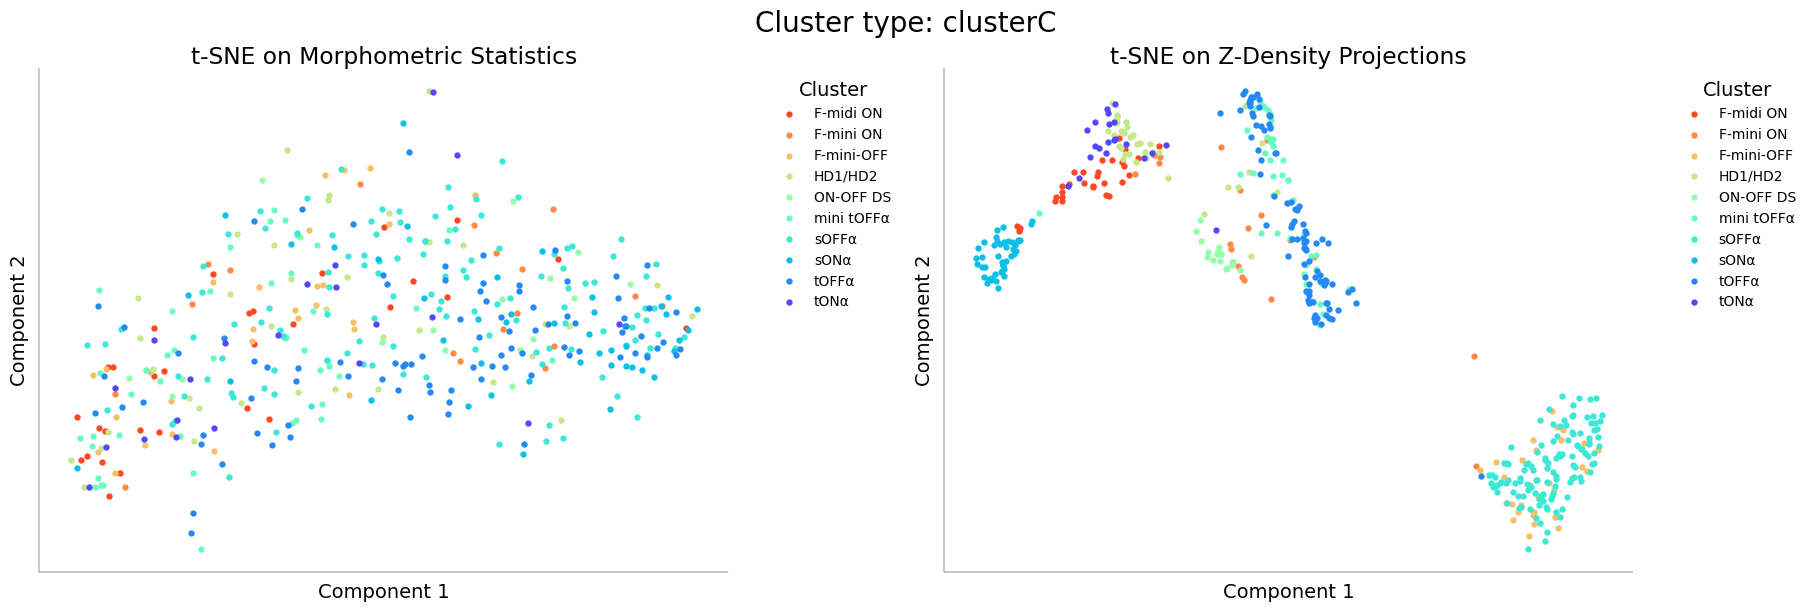

In [15]:
# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------

for ctype in cluster_types:
    # Obtain category assignments and colors for this type
    cat, categories, n_cls, clrmap = cluster_info(labels, ctype)

    # Create new figure per cluster type
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Cluster type: {ctype}", fontsize=20)

    # Plot each cluster category
    for i_lbl, lbl in enumerate(categories):
        idx = np.where(cat == lbl)[0]
        axes[0].scatter(
            emb_stats[idx, 0], emb_stats[idx, 1], color=clrmap[i_lbl], s=50, label=lbl
        )
        axes[1].scatter(
            emb_density[idx, 0],
            emb_density[idx, 1],
            color=clrmap[i_lbl],
            s=50,
            label=lbl,
        )

    # Configure axes and legends
    axes[0].set_title("t-SNE on Morphometric Statistics")
    axes[0].set_xlabel("Component 1")
    axes[0].set_ylabel("Component 2")
    # remove ticks and numbers from the axes
    axes[0].tick_params(
        axis="both", which="both", bottom=False, top=False, left=False, right=False
    )
    axes[0].set_xticklabels([])
    axes[0].set_yticklabels([])
    axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

    axes[1].set_title("t-SNE on Z-Density Projections")
    axes[1].set_xlabel("Component 1")
    axes[1].set_ylabel("Component 2")
    # remove ticks and numbers from the axes
    axes[1].tick_params(
        axis="both", which="both", bottom=False, top=False, left=False, right=False
    )
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout to accommodate legends outside
    plt.show()

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:** The density projection based clusterings produce a strikingly better t-SNE clustering than the morphometric statistics. This might be because the z-position (how deep the neuron goes into/through the IPL) might be a very important feature for different IPL neuron types.

2) What are the advantages of morphometric statistics over density maps 

**Answer:** Morphometric statistics provide clear interpretations and biological meanings for each feature. It might be advantageous to select specific features that are known to be relevant for the population at hand a priori.

3) What are the advantages of density maps over morphometric statistics 

**Answer:** Density maps capture the spatial relations of the whole neurons with all its alements better (esp. 2D density maps) and are less prone to selection bias (morphometric statistics need tp be hand selected beforehand).

## Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------

# Target variable
y = np.array(labels["projection_site"])

# Standardize both feature sets
scaler_stats = StandardScaler()
X_stats_s = scaler_stats.fit_transform(X_stats)
scaler_den = StandardScaler()
X_den_s = scaler_den.fit_transform(X_density)

# Configure logistic regression
clf_stats = LogisticRegressionCV(
    solver="liblinear",
    class_weight="balanced",
    scoring="balanced_accuracy",
    max_iter=1000,
    random_state=17,
    cv=5,
)
clf_den = LogisticRegressionCV(
    solver="liblinear",
    class_weight="balanced",
    scoring="balanced_accuracy",
    max_iter=1000,
    random_state=17,
    cv=5,
)

clf_stats.fit(X_stats_s, y)
clf_den.fit(X_den_s, y)

scores_stats = cross_val_score(
    clf_stats, X_stats_s, y, cv=5, scoring="balanced_accuracy"
)

scores_den = cross_val_score(clf_den, X_den_s, y, cv=5, scoring="balanced_accuracy")


print(
    f"Stats: balanced accuracy = {scores_stats.mean():.3f} ± {scores_stats.std():.3f}"
)
print(f"Density: balanced accuracy = {scores_den.mean():.3f} ± {scores_den.std():.3f}")

Stats: balanced accuracy = 0.691 ± 0.086
Density: balanced accuracy = 0.625 ± 0.048


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

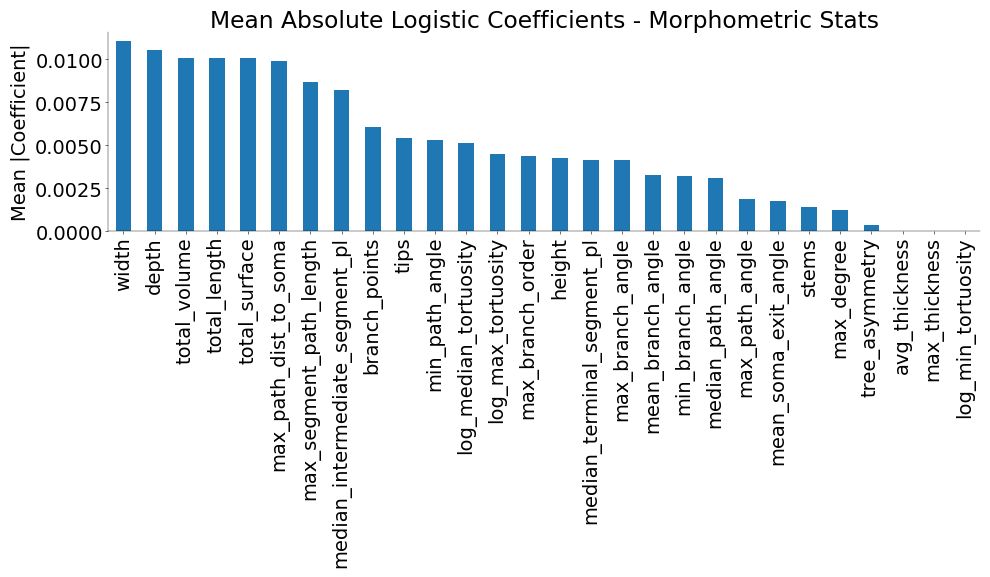

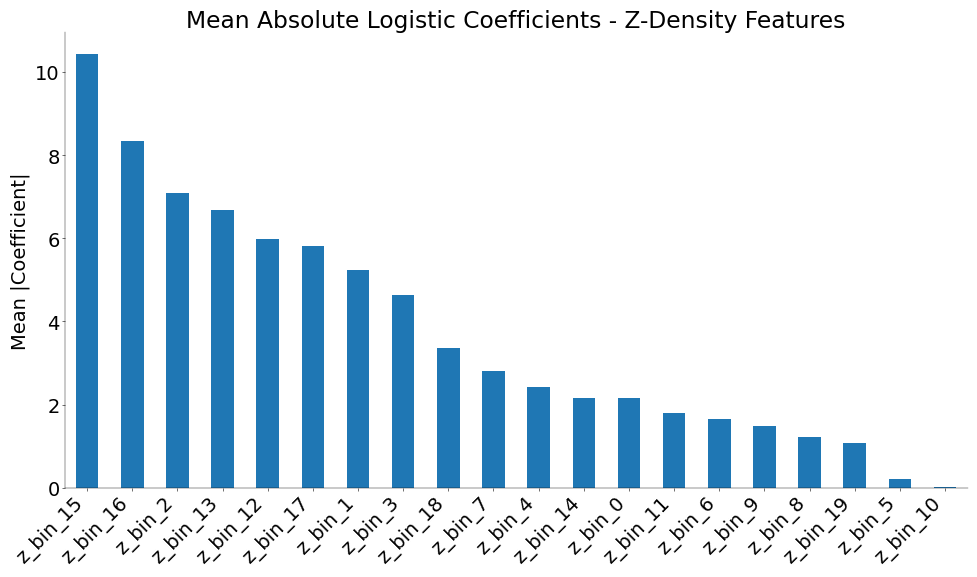

In [17]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------
# Feature relevance: Morphometric statistics
# For multiclass, average absolute coefficient across classes
abs_coefs_stats = pd.Series(np.abs(clf_stats.coef_).mean(axis=0), index=X_stats.columns)
plt.figure(figsize=(10, 6))
abs_coefs_stats.sort_values(ascending=False).plot(kind="bar")
plt.title("Mean Absolute Logistic Coefficients - Morphometric Stats")
plt.ylabel("Mean |Coefficient|")
plt.tight_layout()
plt.show()

# Feature relevance: Z-density features
# Create bin labels from z_centers
z_labels = [f"z_bin_{i}" for i in range(X_den_s.shape[1])]
abs_coefs_den = pd.Series(np.abs(clf_den.coef_).mean(axis=0), index=z_labels)
plt.figure(figsize=(10, 6))
abs_coefs_den.sort_values(ascending=False).plot(kind="bar")
plt.title("Mean Absolute Logistic Coefficients - Z-Density Features")
plt.ylabel("Mean |Coefficient|")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:** width, depth, total valume and total length are the most informative morphometric features for predicting the projection site. This might be interpreted as neuron size being an important factor in determining the projection site. 

## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)